# Use Cars Kaggle Dataset
Proposal of "cleaning" to apply to https://www.kaggle.com/austinreese/craigslist-carstrucks-data/

In [2]:
import pandas as pd
df = pd.read_csv("D:\\data/kaggle-cars/vehicles.csv")

The dataset features the following columns, with a respective number of unique values in those columns:

In [3]:
df.nunique().sort_values()

county               0
drive                3
transmission         3
size                 4
fuel                 5
title_status         6
condition            6
cylinders            8
paint_color         12
type                13
manufacturer        43
state               51
year               111
region             404
region_url         413
price            16305
model            27042
lat              41175
long             41492
odometer         89554
vin             103588
image_url       222413
description     275765
url             423857
id              423857
dtype: int64

We start with ~424k listings want to filter out:
 - duplicate listings (same car, other state, date, ...)
 - scam listings

# Duplicate Listings

For some car listings, we can use the **V**ehicle **I**dentification **N**umber (VIN) to filter out duplicates.

In [12]:
unique_vins = df.drop_duplicates("vin")
unique_vins = unique_vins[~unique_vins.vin.isnull()]
anonymous_cars = df[df.vin.isnull()]
print(f"We have {len(unique_vins) + len(anonymous_cars)} cars remaining.")

We have 343025 cars remaining.


To filter out our cars without a VIN ("anonymous cars"), we first apply a filter to drop all listings which share their description or picture with another listing:

In [13]:
anonymous_cars = anonymous_cars.drop_duplicates("image_url")
anonymous_cars = anonymous_cars.drop_duplicates("description")
print(f"We have {len(unique_vins) + len(anonymous_cars)} cars remaining.")

We have 214018 cars remaining.


Finally, we drop duplicates where at least four out of the following five columns match:

In [14]:
match_cols = ["year", "price", "paint_color", "odometer", "model"]

The idea is that if they match on all five, it would likely be the same car.
We allow matching on just four to account for mistakes made creating the listing, but also:
 - difference in price can be explained by the same car listed later (for cheaper)
 - difference in paint color same car at a dealer that allows one/more colors to be painted inclusive to the price
 - difference in odometer can be explained by the same car listed later
 - year or model: we can't think of a legitimate reason these should not match for the same car if data is entered correctly. However, there can be mistakes [1][2].
 
 [1] Same VIN, different year: df[(df.odometer == 161920) & (df.price ==0)]  
 [2] Same VIN, different model: df[(df.year==1929) & (df.odometer==48441)]

In [34]:
filtered_anonymous_cars = anonymous_cars.copy()
for i, col in enumerate(match_cols):
    filtered_anonymous_cars = filtered_anonymous_cars.drop_duplicates(match_cols[:i] + match_cols[i+1:])
    print(f"Filtering out duplicates that match on all but: {col}")
    print(f"We have {len(unique_vins) + len(filtered_anonymous_cars)} cars remaining.")

Filtering out duplicates that match on all but: year
We have 208336 cars remaining.
Filtering out duplicates that match on all but: price
We have 199568 cars remaining.
Filtering out duplicates that match on all but: paint_color
We have 199331 cars remaining.
Filtering out duplicates that match on all but: odometer
We have 198266 cars remaining.
Filtering out duplicates that match on all but: model
We have 191057 cars remaining.


In [142]:
def show_listing(listing):
    print(f"{listing.image_url.values[0]}")
    print(f"Price: ${listing.price.values[0]}")
    print(f"Description {listing.description.values[0]}")
show_listing(filtered_anonymous_cars.sample())


https://images.craigslist.org/01717_8Tyro8YOzmI_0ww0oo_600x450.jpg
Price: $5000
Description Fantastic car for a first time owner. No wreck history, only two owners, no smokers and although the miles are high, the owner has invested a lot of time and care into this car since ownership three years ago. The list below are all repairs made by the seller in the last year, to assure it is ready to sell. The interior and exterior have minor wear and tear. The drive train is in great condition as well. The AC has a minor leak that needs repairing, but that is a minimal cost for the value bought in the car.   Items replaced or updated: New transmission at 190,000 miles. At 215,000 miles new tires, brakes, drums, air filter, alternator, battery, and radiator.   If interested please text/sms with full first and last name if interested in viewing, test driving, or have follow up questions to the posting.


It's not perfect, but from eyeballing the data (this was based on another notebook) it looked pretty clean of duplicates. However we not been able to create an estimate of the number of duplicate listings still in the dataset (let me know if you have a good idea that is not very labor intensive). We will merge the anonymous cars back with the identified cars:

In [60]:
listings = pd.concat([unique_vins, filtered_anonymous_cars])
listings.shape

(191057, 25)

Finally we also filter out all cars that are outside a reasonable price range. This will remove some valid listings, but should disproportionally filter out scams as well as listings that list price as monthly rate or set an unrealistic price to get bids instead (in either case the indicated price is not a suitable measure of the car's worth).

In [70]:
listings = listings[(listings.price > 2500) & (listings.price < 100_000)]
listings.shape

(163942, 25)

There seem to be several valid listings for less than $2500. However those also include listings which list the price for monthly installments instead of a total price.

# Detecting Scam Listings
We will train a regressor which will aim to predict the price of a car. 
We then investigate predicted prices which differ a lot from their true list price, do they look like scams?

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [95]:
training_features = [ 
    'year', 'manufacturer','model', 'condition', 'cylinders', 'fuel', 'odometer',
    'title_status', 'transmission',  'drive', 'size', 'type', 'paint_color',
    'state', 'lat', 'long'
]
excluded = [
    'id', 'url', 'region', 'region_url', 'price','vin','image_url', 'description','county',
]
as_categorical = [
    'manufacturer','model', 'condition', 'cylinders', 'fuel', 
    'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
    'state', 
]
as_numerical = [
    'year', 'odometer', 'lat', 'long',
]

In [109]:
data = listings[training_features + ["price"]].copy()
for column in as_numerical:
    data[column] = data[column].astype(float)
    data[column].fillna(data[column].median(), inplace=True)
for column in as_categorical:
    data[column] = data[column].astype('category').cat.codes

In [110]:
x_train, x_test, y_train, y_test = train_test_split(data[training_features], data.price)

In [111]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)
predicted_price = forest.predict(x_test)
differences = predicted_price - y_test

<AxesSubplot:ylabel='Frequency'>

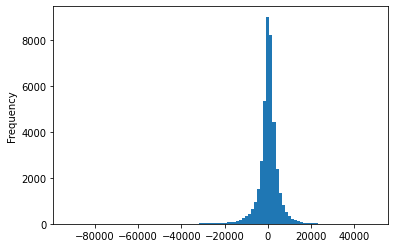

In [113]:
differences.plot.hist(bins=100)

Let's look at extreme examples:

In [148]:
print(f"Undervalued by model by {-differences.min()} dollars")
show_listing(listings.loc[differences[differences == differences.min()].index])

Undervalued by -92275.78
https://images.craigslist.org/00g0g_fhkNK7pjI7U_0CI0t2_600x450.jpg
Price: $98000
Description 07 Ford Expedition EL clean in and out everything works great oh the reason for selling it upgrading please call for more information 9800 or best offer


Note that above looks like a typo in the price (description lists as 9.8k USD instead of 98k USD).

In [166]:
print(f"Overvalued by model by {differences.max()} dollars")
show_listing(listings.loc[differences[differences == differences.max()].index])

Overvalued by model by 48637.75 dollars
https://images.craigslist.org/00e0e_jO3ujlJH5ey_0hT0CI_600x450.jpg
Price: $3500
Description Drops with button goes back up manually  Good engine  Good transmission  Ac Sunroof works  Navigation screen  Leather  Heated seats  Clean title in hand  Bluetooth device included


This does indeed look too cheap for the car, let's look at more cars from the 5%-percentile.

In [167]:
expensive = differences[differences < differences.quantile(0.05)]
cheap = differences[differences > differences.quantile(0.95)]

In [176]:
for index, difference in cheap.sort_values(ascending=False).iteritems():
    print(f"The following listed was overvalued by {difference}:")
    show_listing(listings.loc[[index]])
    print()

The following listed was overvalued by 48637.75:
https://images.craigslist.org/00e0e_jO3ujlJH5ey_0hT0CI_600x450.jpg
Price: $3500
Description Drops with button goes back up manually  Good engine  Good transmission  Ac Sunroof works  Navigation screen  Leather  Heated seats  Clean title in hand  Bluetooth device included

The following listed was overvalued by 43254.28:
https://images.craigslist.org/00b0b_fvORervxO8R_600x450.jpg
Price: $6500
Description New RUNNER Electric Car/Cart by Cheeta Golf - Color Red - $6500 Street ready - equipped with headlights, taillights, horn, windshield wipers, heater, blue tooth, sun roof, etc. Can be used as a golf cart or to motor around the neighborhood. An attachment is available for the back of the cart that accommodates 2 golf bags. Max speed about 25 mph. Drivers seat with a back seat that can accommodate an adult or a couple of small children.  4 wheels / 2 doors For more information - go to Cheetagolf.com  This cart sells for $6900 online. I purc

Price: $7500
Description I am selling a 1967 Ford Galaxie 500. It has a 390 V8 motor and std shift. Great car for conversion to a floor shift. It is complete and in good shape.  E mail me or call 603-523-4524  No Texting

The following listed was overvalued by 18091.53:
https://images.craigslist.org/00L0L_eWdU6cH5doY_0CI0t2_600x450.jpg
Price: $14500
Description All original 1955 Studebaker Regal Commander .Excellent driver condition. Newer interior and headliner, all excellent condition.   224 cu in v8  only a few made, has rebuilt automatic. Complete new wire harness, electronic ignition. Converted to 12 volt system with 1 wire  alternator(comes with original generator. New radials on cragar mags, comes with original wheels and hub caps with coker wide whites.    Have records back to 1995. 269-four 6 four-two 3 six 9.  Car located in White Pigeon Mi. 49099  _________REDUCED to $14500.00_Or Best Offer__________________

The following listed was overvalued by 18078.980000000003:
https:/

https://images.craigslist.org/00x0x_aLRkr8ahPck_600x450.jpg
Price: $33999
Description 2017 Chevrolet Express . Condition was Certified pre-owned when I purchased this in 7/19.  I am not entirely sure that it is transferable or not.  It does have the existing full factory warranty today.    This van gets crazy good mpg.  I have had several diesel vans before, including ford 7.3's and a couple sprinters.  The 7.3 could get 20 mpg with the right axle ratio and the sprinter did better but they are very utilitarian.  I just took this to San Diego and back for thanksgiving and was getting 28 mpg on the freeway doing 70 ish.  That is awesome for a 12 passenger van    I just got back from Idaho with this van and was getting crazy good mpg.  In Nevada and Idaho the speed limit it 80 mph I was still getting at least 28 mpg  This has all the bells and whistles.   It is a LT model back up camera,  navigation,  front and rear a/c and heat,  factory tinted windows,  auto with the manual trans button

The following listed was overvalued by 13163.810000000001:
https://images.craigslist.org/00N0N_eCdsNn9zOS4_0hF0b2_600x450.jpg
Price: $11500
Description 1961 Ford Thunderbird, white with red interior, 68,000 miles, new tires & batteries, in good condition, runs good, $11,500 obo 724-662-57zero9

The following listed was overvalued by 13153.18:
https://images.craigslist.org/00I0I_7aAbQNXWGdC_0ew08a_600x450.jpg
Price: $22995
Description 2017 BMW X1 xDrive28i Sports Activity Vehicle     Offered by: DREAM CAR GALLERY - Bad Credit No Credit - 100% Approval — (516) 217-2070  — $22,995       DREAM CAR GALLERY - Bad Credit No Credit - 100% Approval    Year: 2017 Make: BMW Model: X1 Series: xDrive28i Sports Activity Vehicle  VIN: WBXHT3C37H5F85097  Stock #: F85097 Condition: Used Mileage: 22,179  MPG: 22 city / 31 highway  Exterior: Black Sapphire Metallic  Interior: Canberra Beige  Body: Sport Utility  Transmission: Automatic  Engine: 2 4 Cylinder Engine     💥 DREAM CAR GALLERY - 🚘- Home of the

https://images.craigslist.org/00f0f_btXpcFdhHJq_0jm0ew_600x450.jpg
Price: $19988
Description 📱Call TriCity Auto at: (763)572-2277  WE ARE OPEN!  MAKE AN APPOINTMENT FOR YOUR CONVENIENCE!  ACEPTAMOS NÚMEROS DE ITIN MARTRICULA FINANCING AVAILABLE FOR ALL!!  Exterior Color:White   #10908 THIS HARD TOO FIND LONG BOX IS NOW UP FOR SALE! 6.6L DURAMAX! 6 SPEED AUTOMATIC! 4X4! COLD AC! THIS DURAMAX IS ALL STOCK! Z71! OFF ROAD! RUNS EXCELLENT! THIS ONE YOU CAN PUT TO WORK! GIVE US A CALL @ 763-572-2277.  __________________________________________________________________________   Transmission: Automatic Body: Pickup Doors: 4 Seats: 5 __________________________________________________________________ TriCity Auto 📱(763)572-2277 http://www.tricityautoloans.com/ Location: 4760 Central Ave NE, Columbia Heights, MN 55421 __________________________________________________________________________ ✔️For as low as $999.00 down you can drive off with a new vehicle TODAY! ✔️99% approval rate for all custo

Price: $13995
Description Selling this super clean and very well cared for Chrysler 300 C. Runs, drives and handles as great as it looks! Just push the start button and go. Strong V8 5.7 Hemi engine and automatic transmission. Fully loaded with heated and air conditioned seats, power sunroof, heated steering wheel, XM radio, bluetooth and much more! ONLY 51K MILES!! Clean title and a clean carfax with no accidents ever reported! Like new 22" rims! Overall a strong running car that is ready to go. Financing is available with as little as $3000 down. Terrible credit is no problem here. Trades and credit cards are welcome. Call/text for any questions you may have 856-796-6596 or call the office at 856-318-7819.  We have other vehicles for sale on our website at www.premiumautooutlet.com

The following listed was overvalued by 11181.43:
https://images.craigslist.org/01414_9QGwOUFjM9P_0cO09G_600x450.jpg
Price: $9499
Description Drive it home today. Call (Or Text) us now !!Call (or text) ☏ 5

Description Up for sale is one awesome 2016 Ram 1500 SLT 4x4 pick-up! This is a very clean truck that has been well maintained and properly cared for. The exterior is absolutely beautiful.. brand new tires and brakes. All around the condition of this truck is well above average.. Hemi 5.7L V8 power with 4x4! Make your appointment today.  **We will deliver for free, anywhere within a 150 miles radius of our dealership.   ** Do you have a mechanic that you prefer to use for an inspection? Set-up the appointment and we will make sure the vehicle is there and ready!   ** Have a trade-in?? We accept all vehicles.. when inquiring about a trade-in, please have a couple pics and VIN ready for we can do a history / market value report.   ** Discounts available to all active military and first responder personnel. Please review the pics and feel free to ask any and all questions. We are a family owned and operated dealership with over 41 years of experience. We would greatly appreciate the oppor

https://images.craigslist.org/00w0w_9WoQwi3yhZR_0sU0dm_600x450.jpg
Price: $9500
Description 5,500 miles Special Edition Numbered Bike It is #34 of 200 made Kept in a heated garage Motorcycle has performance chip and has been Dino tested (very fast) Over $10,000 in upgrades and chrome One of a kind! Must See  Mack1 Auto 329 S Keyser Ave Taylor, Pa 18517

The following listed was overvalued by 9804.5:
https://images.craigslist.org/00t0t_ePGrDlT6Gjc_0CI0t2_600x450.jpg
Price: $18900
Description 2014 Freightliner Cascadia Sleepers    Over 60 units available Miles range from 550,000 to 650,000  Fleet maintained  $18900  you pick and choose  * DD13  450 horse power  12.8L Engine * 10 Speed Eaton Fuller Manual Transmission * 213 wheel base * 3.58 gear ratio * 12,500 front axle * 40,000 rear axle * air ride suspension * ice cold ac * Good tire tread * aluminum wheels * single bunk * jake breaks * air slide 5th wheel   All trucks are located in Houston, Texas  Fly into any airport in Houston we 

https://images.craigslist.org/00Q0Q_1phHriuCVQC_0gw0co_600x450.jpg
Price: $29998
Description For more information on this Ram and to access a complimentary CARFAX vehicle history report, copy this link into your browser: http://atmxi.com/351598/2442202I227 -------------------------------------------------------------------------------------------------------------📲 CALL OR TEXT US (406) 200-8818 📲and use stock number: 23486ZA to confirm availability instantly! -------------------------------------------------------------------------------------------------------------  SPECIFICATIONS          YEAR:   2016        MAKE:   Ram     MODEL:   5500 Chassis   STOCK #:   23486ZA              VIN:   3C7WRNFL7GG253677          TRIM:   Tradesman Crew Cab Cab & Chassis  MILEAGE:   256,771      COLOR:   White / Diesel Gray/Black         BODY:   Crew Cab Chassis-Cab       TRANS:   Automatic         AD ID:   7AC0EB6BCAF0D3BF    ENGINE:   6.7 6  Cyl          FUEL:   Diesel       DRIVE:   4WD; Dual Rear

https://images.craigslist.org/00909_1sL9vUPwqId_0ak07K_600x450.jpg
Price: $16500
Description Why Buy From Lumin Auto Group?Let Lumin Auto Group show you how easy it is to buy a quality used car in New Smyrna Beach. We believe fair prices, superior service, and treating customers right leads to satisfied repeat buyers. Our Friendly and knowledgeable sales staff is here to help you find the car you deserve, priced to fit your budget. Shop our virtual showroom of used cars, trucks and suv's online then stop by for a test drive. Stock# 26069386-800-1020 - Call now for your best deal!For all details on this vehicle, visit:http://cl-car.dealersync.com/5639942-53541 Vehicle OverviewTrim: Work Truck pickup Mileage: 51k miles Exterior Color: Silver Ice Metallic Interior Color:  Engine: 4.3L 6 Cylinders Drive: rwd Transmission: Automatic VIN:  1GCNCNEH4HZ137944Seller Comments: Our One Owner 2017 Chevrolet Silverado 1500 WT Regular Cab 4X2 projects strength and capability in Silver Ice Metallic! 

https://images.craigslist.org/00n0n_hyMO6heovmd_0x20lW_600x450.jpg
Price: $6500
Description Great wood haler truck. Engine runs great body is in ruff condition. All glass is fine. Heavy duty grill guard. Price is or best offer.

The following listed was overvalued by 8566.21:
https://images.craigslist.org/01313_ahUv8mLjkon_0gw0co_600x450.jpg
Price: $18990
Description Carvana is the safer way to buy a car During these uncertain times, Carvana is dedicated to ensuring safety for all of our customers. In addition to our 100% online shopping and selling experience that allows all customers to buy and trade their cars without ever leaving the safety of their house, we’re providing touchless delivery that make all aspects of our process even safer. Now, you can get the car you want, and trade in your old one, while avoiding person-to-person contact with our friendly advocates. There are some things that can’t be put off. And if buying a car is one of them, know that we’re doing everything we

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Looking at the ads, the outliers seem _mostly_ fair they are:
 - motor cycles
 - misc. vehicles (golfcart-like electric minivehicles, bus, quad-like thing)
 - old cars (with e.g. engine missing)
 - 'new' second hand cars (value plummets after driving off the lot)